# Credit Card Fraud Detection Using Autoencoder

## Declare required dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Data ingestion

In [2]:
df = pd.read_csv('data/creditcard.csv')

## Data exploration

In [3]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(df.shape)
print(df.describe())

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271

## Is there any data missing ?

In [5]:
df.isnull().values.any()

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

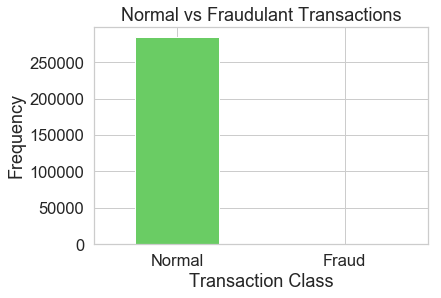

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Our dataset is very highly imbalanced in favour of negative(0, i.e normal) class. This requires further data exploration

In [8]:
fraudsDF = df[df.Class == 1]
normalDF = df[df.Class == 0]

In [9]:
fraudsDF.shape

(492, 31)

In [10]:
normalDF.shape

(284315, 31)

Let's now look at the amount of money involved across two classes

In [11]:
fraudsDF.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normalDF.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Graphically speaking ...`

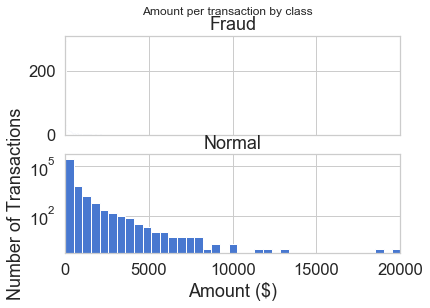

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Does time of transaction have any bearing on fraudulent activity

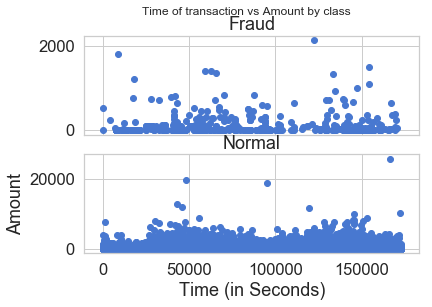

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Time, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Time, normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

So, it is clear that time of transaction has no bearing on the fraudulent activity.

## Preprocessing

Since, as shown above, time of transaction has no bearing on fraudulent activity, this feature is not going to contribute to model learning. Hence we can drop it. 

In [15]:
transactionData = df.drop(['Time'], axis=1)

Also let us standardize the feature Amount.

In [16]:
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1, 1))

### Split the dataset in training and test datasets

We split the dataset as Training=80% and Test=20%. Training dataset will have only normal transactions and test dataset will have both normal and fraudulent transactions.

In [17]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
#print(type(X_train))
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


56962


## Model
We will build the autoencoder consisting of 4 fully connected layers with 14,7,7,29 neurons. First 2 layers act as encoder and last 2 layers act as decoder. Note last layer has 29 nodes corresponding to 29 feature in the input data item.

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )
        
        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 29),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
model = Autoencoder().double().cpu()

In [20]:
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

In [21]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [22]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [24]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [25]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    

torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.8037
epoch [2/100], loss:0.7337
epoch [3/100], loss:0.7217
epoch [4/100], loss:0.7155
epoch [5/100], loss:0.7106
epoch [6/100], loss:0.7082
epoch [7/100], loss:0.7064
epoch [8/100], loss:0.7052
epoch [9/100], loss:0.7041
epoch [10/100], loss:0.7034
epoch [11/100], loss:0.7030
epoch [12/100], loss:0.7025
epoch [13/100], loss:0.7024
epoch [14/100], loss:0.7020
epoch [15/100], loss:0.7014
epoch [16/100], loss:0.7015
epoch [17/100], loss:0.7013
epoch [18/100], loss:0.7012
epoch [19/100], loss:0.7014
epoch [20/100], loss:0.7010
epoch [21/100], loss:0.7008
epoch [22/100], loss:0.7009
epoch [23/100], loss:0.7009
epoch [24/100], loss:0.7008
epoch [25/100], loss:0.7008
epoch [26/100], loss:0.7008
epoch [27/100], loss:0.7009
epoch [28/100], loss:0.7008
epoch [29/100], loss:0.7008
epoch [30/100], loss:0.7007
epoch [31/100], loss:0.7007
epoch [32/100], loss:0.7007
epoch [33/100], loss:0.7007
epoch [34/100], loss:0.7007
epoch [35/100], loss:0.7007
epoch [36/100], loss:0.7005
e

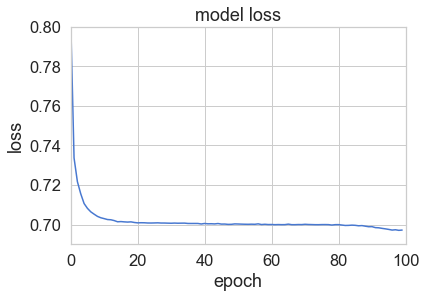

In [36]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.69,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Evaluation

In [27]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [28]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,56962.000000
mean,0.727691,0.001720
std,3.463443,0.041443
min,0.038527,0.000000
25%,0.235004,0.000000
50%,0.384621,0.000000
75%,0.612894,0.000000
max,258.000434,1.000000


In [29]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,56962.000000
mean,0.727691,0.001720
std,3.463443,0.041443
min,0.038527,0.000000
25%,0.235004,0.000000
50%,0.384621,0.000000
75%,0.612894,0.000000
max,258.000434,1.000000


# Reconstruction Errors without Fraud

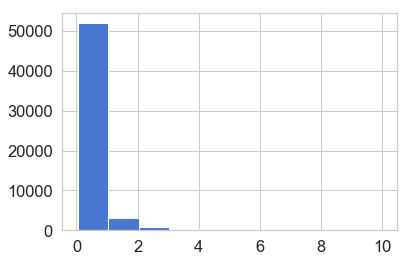

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

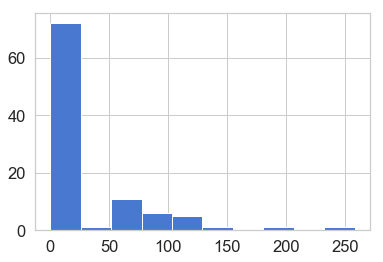

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

The receiver operating characteristics curve, or ROC curve for short are used very commonly for analysing the binary classifiers. It considers all possible thresholds for a given classifier and shows false positive rate (FPR) against true positive rates (TPR)


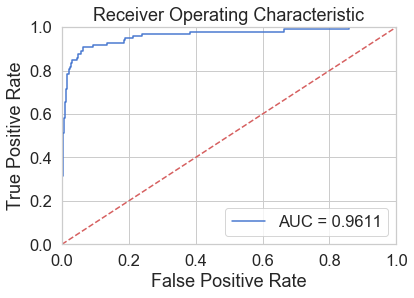

In [32]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Setting a  threshold that is used to make a classification decision in a model is a way to adjust the trade-off of precision and recall for a given classifier.

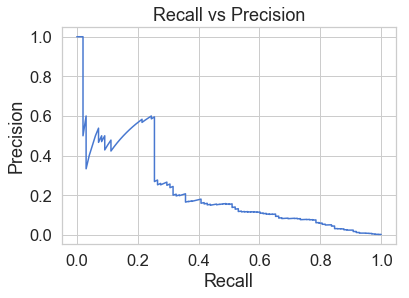

In [33]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

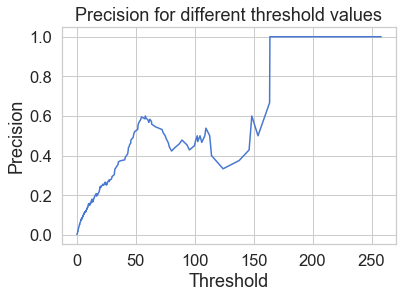

In [37]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:


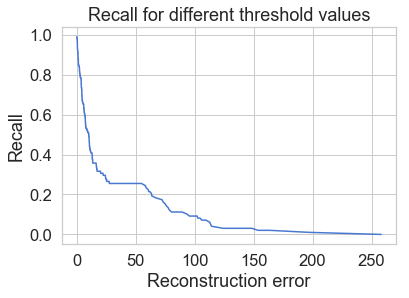

In [38]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

## Using the Model to make prediction

In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [39]:
threshold = 2.9

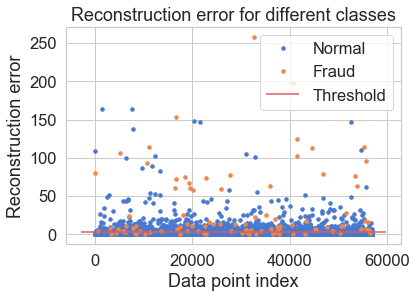

In [42]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

 Let's have a look at the confusion matrix:

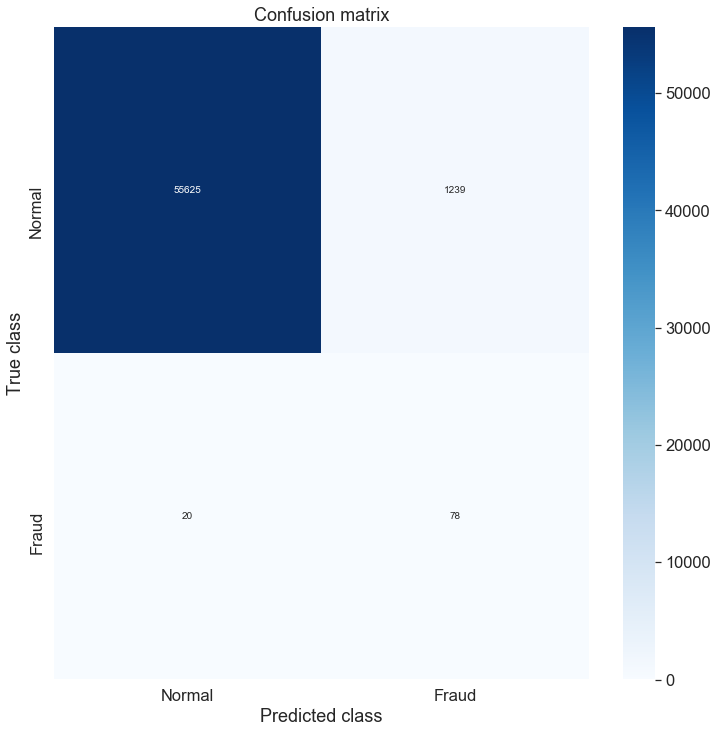

In [34]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. But the number of normal transactions classified as frauds is really high.  One can tweak the threshold here and there to come up with better results.

## Conclusion

We've created a very simple Deep Autoencoder in PyTorch that can reconstruct what non fraudulent transactions looks like. It has learnt to recognise the non fraudulent transactions by learning some patterns present in the those transactions, what those patterns are that is hard to tell - a mystery of any deep learning neural network.

PyTorch gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. One can attempt building the similar autoencoder using a different framework e.g like Tensorflow/Keras/fast.ai for a different domain/problem e.g classifying images as containing inappropriate content